<a href="https://colab.research.google.com/github/juliogr8/Proyecto-SP1-Car-Evaluation/blob/main/Proyecto_SP1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Car Evaluation using AI

## Authors & Affiliations
Jorge Cuevas 22000138, Julio Gudiel 18001201
Seminario Profesional I - AN FISICC Universidad Galileo Fecha: 23 de mayo de 2025

## Importing necessary classes

In [1]:
# Imports Libraries

# Main library
import tensorflow as tf

# For graph plotting
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from tensorflow.math import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, accuracy_score

# For dataset manipulation
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.preprocessing import OrdinalEncoder
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# For visualizing graphs
import seaborn as sns

## Retrieving Dataset

In [2]:
#Retrieves Dataset from https://archive.ics.uci.edu/dataset/19/car+evaluation

!wget https://archive.ics.uci.edu/static/public/19/car+evaluation.zip
!unzip car+evaluation.zip

--2025-05-26 20:01:21--  https://archive.ics.uci.edu/static/public/19/car+evaluation.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘car+evaluation.zip’

car+evaluation.zip      [ <=>                ]   6.19K  --.-KB/s    in 0s      

2025-05-26 20:01:22 (58.8 MB/s) - ‘car+evaluation.zip’ saved [6342]

Archive:  car+evaluation.zip
  inflating: car.c45-names           
  inflating: car.data                
  inflating: car.names               


## Loading Dataset

In [3]:
# Loads dataset and assigns column names

column_names = ['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'class']
data = pd.read_csv('car.data', header=None, names=column_names, sep=",")


### Visualizing Raw data

In [4]:
# Prints out the number of Instances and columns respectively
data.shape

(1728, 7)

In [5]:
# Prints out the first 10 instances of the Dataset
data.head(10)

,buying,maint,doors,persons,lug_boot,safety,class
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc
5,vhigh,vhigh,2,2,med,high,unacc
6,vhigh,vhigh,2,2,big,low,unacc
7,vhigh,vhigh,2,2,big,med,unacc
8,vhigh,vhigh,2,2,big,high,unacc
9,vhigh,vhigh,2,4,small,low,unacc


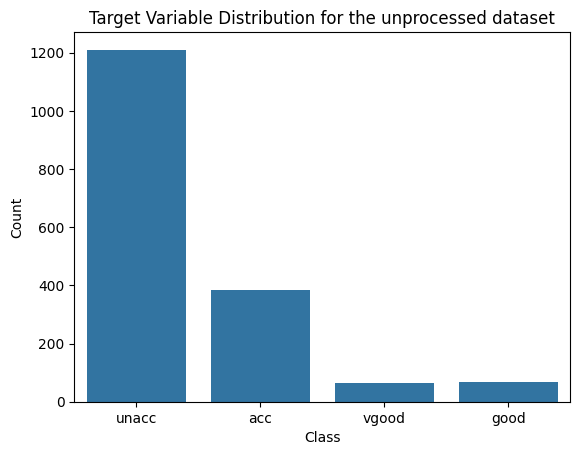

In [6]:
# Plots a distribution graph of instances for each class of the target variable
sns.countplot(x='class', data=data)
plt.title('Target Variable Distribution for the unprocessed dataset')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

## Data Pre-processing

### Applying Ordinal Encoding

In [7]:
# Creates an OrdinalEncoder instance for features
feature_encoder = OrdinalEncoder(categories=[['low', 'med', 'high', 'vhigh'],
                                             ['low', 'med', 'high', 'vhigh'],
                                             ['2', '3', '4', '5more'],
                                             ['2', '4', 'more'],
                                             ['small', 'med', 'big'],
                                             ['low', 'med', 'high']])

# Creates a separate OrdinalEncoder instance for the target variable
target_encoder = OrdinalEncoder(categories=[['unacc', 'acc', 'good', 'vgood']])

# Encodes features
encoded_features = feature_encoder.fit_transform(data[['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety']])
encoded_features = pd.DataFrame(encoded_features, columns=['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety'])

# Encodes target variable
encoded_target = target_encoder.fit_transform(data[['class']])
encoded_target = pd.DataFrame(encoded_target, columns=['class'])

# Drops original columns and concatenates encoded data
data = data.drop(['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'class'], axis=1)
data = pd.concat([data, encoded_features, encoded_target], axis=1)

### Applying Data Augmentation

In [8]:
# Gets the current class counts
class_counts = Counter(encoded_target['class'])

# Creates the sampling strategy dictionary for Oversampling
adjusted_proportions = {
    # Majority class proportion stays the same
    0: int(class_counts[0] * 1),
    # Increases minority classes proportions
    1: int(class_counts[0] * 0.6),
    2: int(class_counts[0] * 0.4),
    3: int(class_counts[0] * 0.4)
}

# Creates the SMOTE object with the sampling strategy
# Set random State 42 so that the state can be replicated every time
over = SMOTE(sampling_strategy=adjusted_proportions, random_state=42)
resampled_features, resampled_target = over.fit_resample(encoded_features, encoded_target)

resampled_features = pd.DataFrame(resampled_features, columns=encoded_features.columns)
resampled_target = pd.DataFrame(resampled_target, columns=['class'])

# Creates a new dataframe with the resampled data
balanced_data = pd.concat([resampled_features, resampled_target], axis=1)

### Visualizing Processed Data

In [9]:
# Prints out number of Instances and columns of the newly processed Dataset
balanced_data.shape

(2904, 7)

In [10]:
# Prints out the last 10 instances of the Dataset
balanced_data.tail(10)

,buying,maint,doors,persons,lug_boot,safety,class
2894,1.000000,0.000000,0.000000,1.50272,2.000000,2.0,3.0
2895,0.232213,0.000000,1.000000,2.00000,1.000000,2.0,3.0
2896,0.000000,1.000000,2.100425,1.00000,2.000000,2.0,3.0
2897,1.000000,0.000000,1.383891,1.00000,2.000000,2.0,3.0
2898,0.000000,2.000000,1.543553,2.00000,2.000000,2.0,3.0
2899,0.000000,2.000000,1.906472,1.00000,2.000000,2.0,3.0
2900,1.000000,0.624238,1.000000,2.00000,2.000000,2.0,3.0
2901,0.000000,2.000000,2.883102,1.00000,1.883102,2.0,3.0
2902,0.939832,0.000000,1.000000,2.00000,2.000000,2.0,3.0
2903,0.000000,1.000000,1.000000,2.00000,1.372292,2.0,3.0


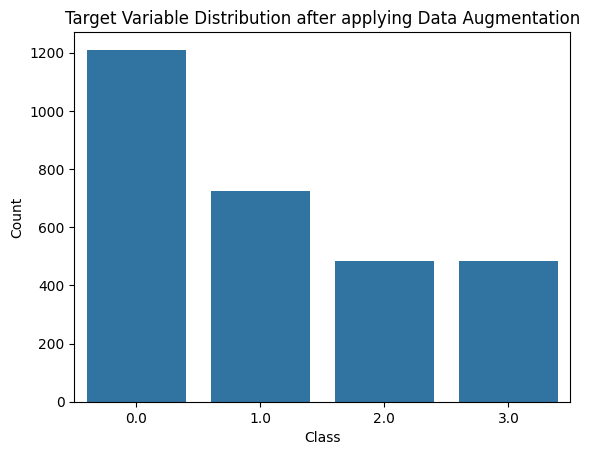

In [11]:
# Plots a distribution graph for the newly distributed dataset
sns.countplot(x='class', data=balanced_data)
plt.title('Target Variable Distribution after applying Data Augmentation')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

## Model Training

In [12]:
# Checking for null values
print(balanced_data.isna().sum())

buying      0
maint       0
doors       0
persons     0
lug_boot    0
safety      0
class       0
dtype: int64


### Data Splitting

In [13]:
# Splitting dataset into training and testing sets
train, test = train_test_split(balanced_data, test_size=0.2)

train_features = train[resampled_features.columns]
train_target = train[resampled_target.columns]

test_features = test[resampled_features.columns]
test_target = test[resampled_target.columns]

In [14]:
# Prints out the newly split sets for training and testing
train_target, test_target

(      class
 1660    1.0
 2465    2.0
 487     0.0
 320     1.0
 2841    3.0
 ...     ...
 1177    1.0
 1203    0.0
 139     0.0
 1696    2.0
 1791    1.0
 
 [2323 rows x 1 columns],
       class
 1998    1.0
 830     1.0
 2730    3.0
 1672    2.0
 526     0.0
 ...     ...
 1571    0.0
 1631    2.0
 1427    1.0
 1912    1.0
 339     0.0
 
 [581 rows x 1 columns])

### Defining and training the model

In [15]:
# Defines the model
model = tf.keras.Sequential([
    # Input layer with 6 features
    tf.keras.layers.Input(shape=(6,)),
    # Hidden layer with 64 neurons and Relu activation
    tf.keras.layers.Dense(64, activation='relu'),
    # Another hidden layer with 32 nuerons
    tf.keras.layers.Dense(32, activation='relu'),
    # Output layer with 4 classes and softmax activation
    tf.keras.layers.Dense(4, activation='softmax')
])

# Compiles the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Trains the model
history = model.fit(train_features, train_target, epochs=10, batch_size=32)

Epoch 1/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4004 - loss: 1.2887
Epoch 2/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7206 - loss: 0.8154
Epoch 3/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8433 - loss: 0.5440
Epoch 4/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8596 - loss: 0.4523
Epoch 5/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8886 - loss: 0.3679
Epoch 6/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9231 - loss: 0.2993
Epoch 7/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9295 - loss: 0.2615
Epoch 8/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9343 - loss: 0.2273
Epoch 9/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9276 - loss: 0.2237
Epoch 10/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9386 - loss: 0.1933


### Visualizing Training Results

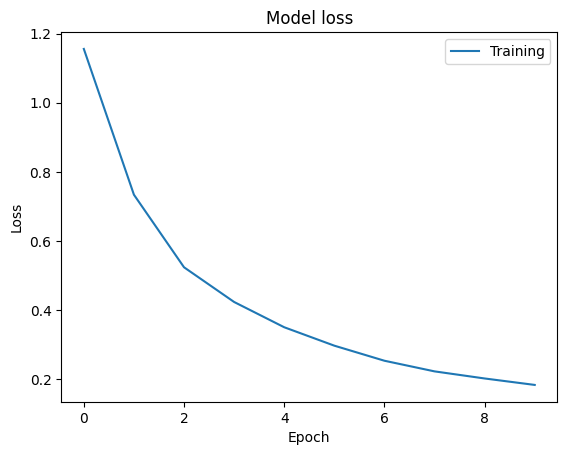

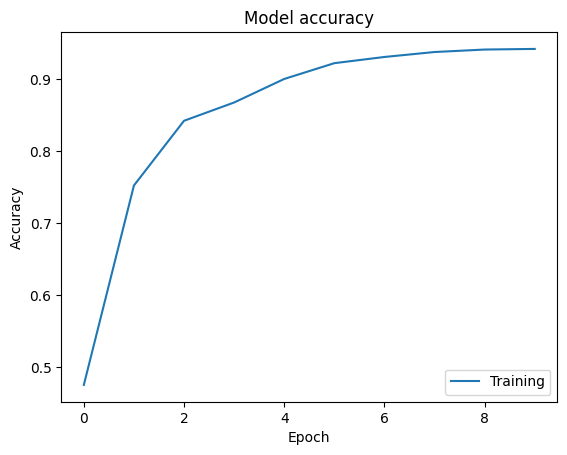

In [16]:
# Plots training loss
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training'], loc='upper right')
plt.show()

# Plots training accuracy
plt.plot(history.history['accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training'], loc='lower right')
plt.show()

### Evaluating the model

In [17]:
# Evaluates the model
test_loss, test_acc = model.evaluate(test_features, test_target)
print(f'Test accuracy: {test_acc}')

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9621 - loss: 0.1397
Test accuracy: 0.955249547958374


### Visualizing Metrics and Testing Results

In [18]:
# Makes predictions on the test set
predictions = model.predict(test_features)
# Gets predicted class labels
predicted_labels = tf.argmax(predictions, axis=1)

# Converts tensors to NumPy arrays for compatibility with sklearn
predicted_labels = predicted_labels.numpy()
# Flattens true labels to 1D array
true_labels = test_target.values.ravel()

# Calculates precision, recall, and F1-score
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')

# Prints the metrics
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Precision: 0.9552068987529583
Recall: 0.955249569707401
F1-score: 0.9550810710948322


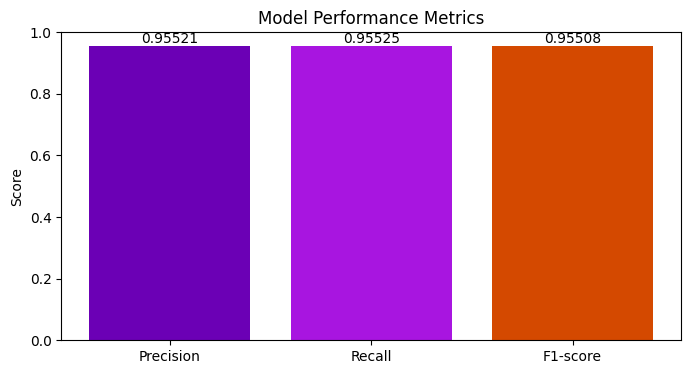

In [19]:
# Stores metrics in a list
metrics = [precision, recall, f1]
metric_names = ['Precision', 'Recall', 'F1-score']

# Creates a Performance bar chart
plt.figure(figsize=(8, 4))
plt.bar(metric_names, metrics, color=['#6b00b5', '#a815e0', '#d44900'])
plt.title('Model Performance Metrics')
plt.ylabel('Score')

# Sets y-axis limits to 0-1 for better visualization
plt.ylim(0, 1)

# Adds value labels above each bar
for i, v in enumerate(metrics):
    plt.text(i, v, str(round(v, 5)), ha='center', va='bottom')

plt.show()

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


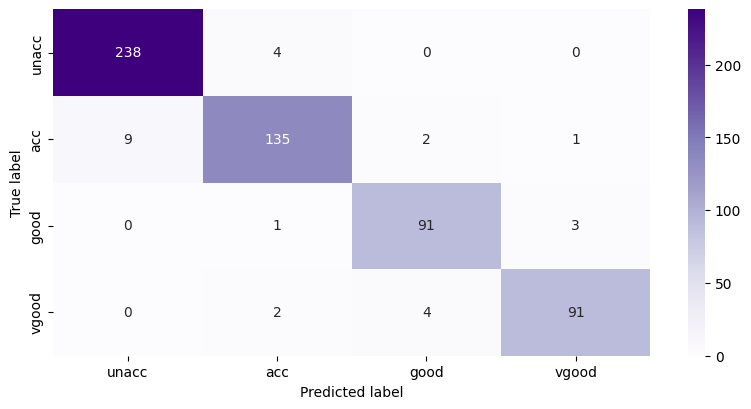

In [20]:
# Function that plots confusion matrix
def plot_confusion_matrix(labels, predictions):
  # Assigns original names back to labels for better visualization
  class_names = ['unacc', 'acc', 'good', 'vgood']
  figure = plt.figure(figsize=(8, 4))
  # Uses xticklabels and yticklabels to display class names
  sns.heatmap(confusion_matrix(labels=labels, predictions=predictions), annot=True, fmt='g', cmap=plt.cm.Purples, xticklabels=class_names, yticklabels=class_names)
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

# Confusion Matrix
predictions = list(map(lambda x: np.argmax(x), model.predict(test_features)))

plot_confusion_matrix(labels=test_target, predictions=predictions)

## Implementation of Alternative models

### Random Forest algorithm

#### Dataset Splitting


In [21]:
# 70% for training & 30% for testing
X_train, X_test, y_train, y_test = train_test_split(resampled_features, resampled_target, test_size=0.3, random_state=42)


#### Building and Training the Model

In [22]:
# - n_estimators=100 → Uses 100 Decision trees
# - random_state=42 → For consistent Results
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train.to_numpy().ravel())
# Makes predictions with the testing data
y_pred_rf = rf.predict(X_test)

#### Visualizing Metrics and Errors

🔍 Random Forest Metrics:
              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99       369
         1.0       0.98      0.99      0.98       206
         2.0       0.98      1.00      0.99       157
         3.0       0.99      1.00      1.00       140

    accuracy                           0.99       872
   macro avg       0.99      0.99      0.99       872
weighted avg       0.99      0.99      0.99       872



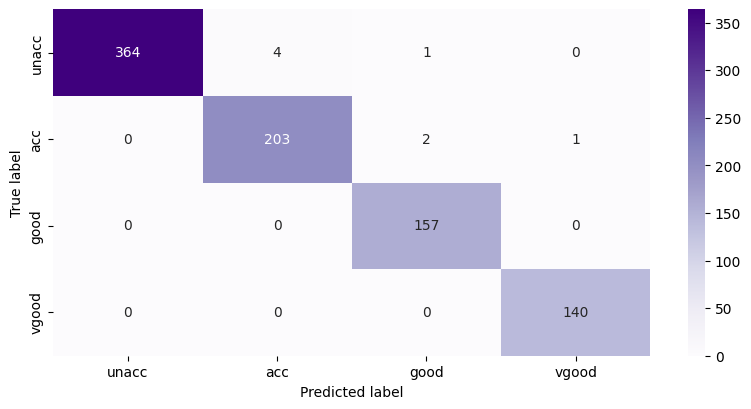

Accuracy: 0.9908256880733946


In [23]:
# Evaluates model
print("🔍 Random Forest Metrics:")
# Shows Precision, Recall and F1-Score metrics
print(classification_report(y_test, y_pred_rf))

# Function that plots confusion matrix
class_names = ['unacc', 'acc', 'good', 'vgood']
cm_rf = confusion_matrix(y_test, y_pred_rf)
figure = plt.figure(figsize=(8, 4))
sns.heatmap(cm_rf, annot=True, fmt='g', cmap=plt.cm.Purples, xticklabels=class_names, yticklabels=class_names)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Shows Prediction vs Test results comparison
rf_acc = accuracy_score(y_test, y_pred_rf)
print("Accuracy:", rf_acc)

### SVM (Support Vector Machine)

#### Building and Training the SVM Model

In [24]:
# Separates clases with a straight line, Regularization parameter, Creation seed
svm=SVC(kernel='linear',C=1,random_state=42)
svm.fit(X_train, y_train.to_numpy().ravel())


SVC(C=1, kernel='linear', random_state=42)

#### Predictions and Evaluation


🔍 SVM Metrics:
              precision    recall  f1-score   support

         0.0       0.88      0.87      0.87       369
         1.0       0.78      0.78      0.78       206
         2.0       0.91      0.95      0.93       157
         3.0       0.99      0.96      0.97       140

    accuracy                           0.88       872
   macro avg       0.89      0.89      0.89       872
weighted avg       0.88      0.88      0.88       872



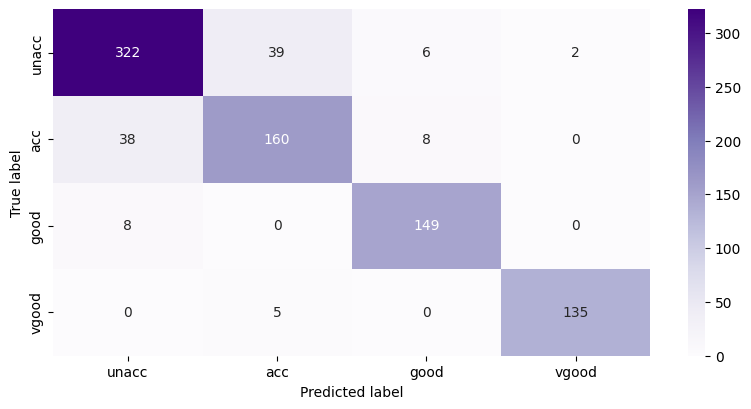

Accuracy: 0.8784403669724771


In [25]:
# Predicts test results and shows errors
y_pred_svm = svm.predict(X_test)
print("\n🔍 SVM Metrics:")
print(classification_report(y_test, y_pred_svm))
class_names = ['unacc', 'acc', 'good', 'vgood']
cm_svm = confusion_matrix(y_test, y_pred_svm)
figure = plt.figure(figsize=(8, 4))
sns.heatmap(cm_svm, annot=True, fmt='g', cmap=plt.cm.Purples, xticklabels=class_names, yticklabels=class_names)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()
svm_acc = accuracy_score(y_test, y_pred_svm)
print("Accuracy:", svm_acc)